                                            SALARY PREDICTION MODEL

# IMPORTS

In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# LOAD DATA

In [338]:
df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                   names=["age", "workclass", "fnlwgt", "education", "education-num",
                          "marital-status", "occupation", "relationship", "race", "sex",
                          "capital-gain", "capital-loss", "hours-per-week", "native-country", "label"])
df_test=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                   names=["age", "workclass", "fnlwgt", "education", "education-num",
                          "marital-status", "occupation", "relationship", "race", "sex",
                          "capital-gain", "capital-loss", "hours-per-week", "native-country", "label"])

In [339]:
df_test["marital-status"].unique()

array([nan, ' Never-married', ' Married-civ-spouse', ' Widowed',
       ' Divorced', ' Separated', ' Married-spouse-absent',
       ' Married-AF-spouse'], dtype=object)

# INITIAL DATA ANALYSIS

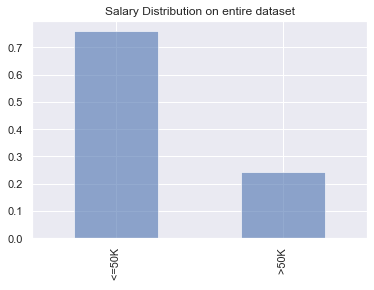

In [340]:
plt.title("Salary Distribution on entire dataset")
df["label"].value_counts(normalize=True).plot(kind="bar", alpha=0.6)

### More than 70% people in dataset have <=50K salary

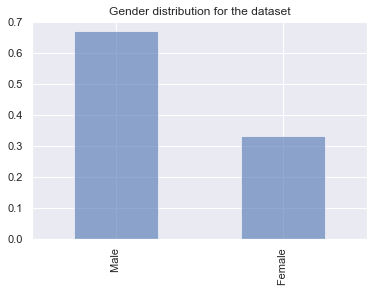

In [341]:
plt.title("Gender distribution for the dataset")
df["sex"].value_counts(normalize=True).plot(kind="bar", alpha=0.6)

### More than 65% people in dataset are Male

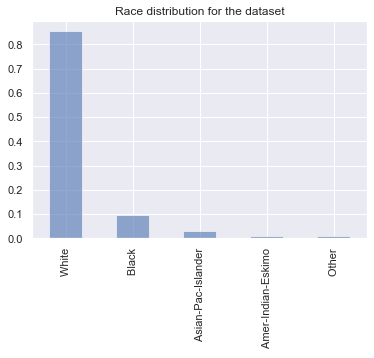

In [342]:
plt.title("Race distribution for the dataset")
df["race"].value_counts(normalize=True).plot(kind="bar", alpha=0.6)

### More than 90% of the people in dataset are White

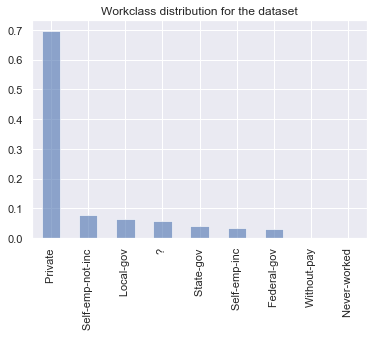

In [343]:
plt.title("Workclass distribution for the dataset")
df["workclass"].value_counts(normalize=True).plot(kind="bar", alpha=0.6)

### Close to 70% of people in dataset are working in private jobs

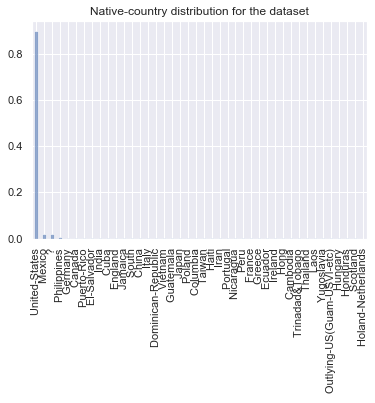

In [344]:
plt.title("Native-country distribution for the dataset")
df["native-country"].value_counts(normalize=True).plot(kind="bar", alpha=0.6)

### More than 90% of the people in dataset are from United States

## INFERENCES

# DATA ANALYSIS WITH 'PCA'

In [345]:
features = ["age", "education-num", "capital-gain"]
x = df.loc[:, features].values

In [346]:
y = df.loc[:,['label']].values

In [347]:
x = StandardScaler().fit_transform(x)

In [348]:
pd.DataFrame(data = x, columns = features).head()

,age,education-num,capital-gain
0,0.030671,1.134739,0.148453
1,0.837109,1.134739,-0.145920
2,-0.042642,-0.420060,-0.145920
3,1.057047,-1.197459,-0.145920
4,-0.775768,1.134739,-0.145920


In [349]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head(5)

,principal component 1,principal component 2
0,0.791425,-0.568577
1,0.958560,0.154112
2,-0.367359,0.194601
3,-0.338532,1.527762
4,0.233831,-1.221324


In [350]:
finalDf = pd.concat([principalDf, df[['label']]], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,label
0,0.791425,-0.568577,<=50K
1,0.958560,0.154112,<=50K
2,-0.367359,0.194601,<=50K
3,-0.338532,1.527762,<=50K
4,0.233831,-1.221324,<=50K


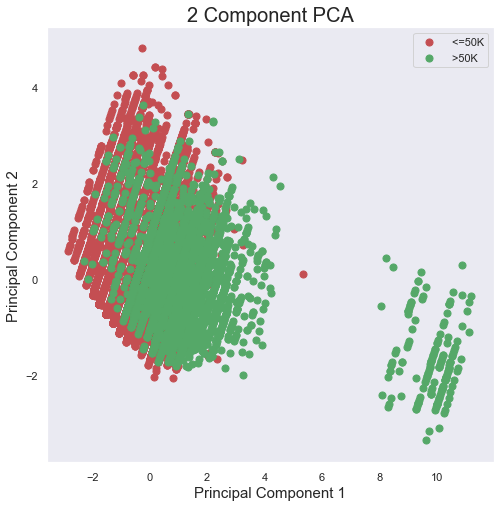

In [351]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


labels = [' <=50K', ' >50K']
colors = ['r', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = finalDf['label'] == label
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.grid()

# DATA PREPROCESSING

## DATA FIXING

In [352]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
label             0
dtype: int64

In [353]:
df_test.isnull().sum()

age               0
workclass         1
fnlwgt            1
education         1
education-num     1
marital-status    1
occupation        1
relationship      1
race              1
sex               1
capital-gain      1
capital-loss      1
hours-per-week    1
native-country    1
label             1
dtype: int64

### Some occupations have value ' ?' where working is 'Never-worked', renaming that to 'None'

In [354]:
def updateOccupationForNeverWorked(x):
    if ((x["occupation"]==" ?") & (x["workclass"]!=" ?")):
        x["occupation"]="None"
    return x

In [355]:
df=df.apply(updateOccupationForNeverWorked, axis=1)
df_test=df_test.apply(updateOccupationForNeverWorked, axis=1)

### Replacing records witth missing workclass and occupation with mode

In [356]:
df["occupation"].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1836
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
None                     7
Name: occupation, dtype: int64

In [357]:
df["workclass"].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

### Replacing missing occupation with '' as random forest classifier is good at predicting missing values

In [358]:
def replaceMissingOccupation(row):
    if(row["occupation"]==" ?"):
        row["occupation"]=""
    return row

In [359]:
df=df.apply(replaceMissingOccupation, axis=1)
df_test=df_test.apply(replaceMissingOccupation, axis=1)

### Replacing missing workclass with '' as random forest classifier is good at predicting missing values

In [360]:
def replaceMissingWorkclass(row):
    if(row["workclass"]==" ?"):
        row["workclass"]=""
    return row

In [361]:
df=df.apply(replaceMissingWorkclass, axis=1)
df_test=df_test.apply(replaceMissingWorkclass, axis=1)

#### NOTE: We are replacing here and not removing because Random Forest algo is really good at predicting missing values so removing these records might bring down the accuracy.

### Converting age from 'string' to 'int' in Test Data and removing first row of data

In [362]:
df_test.drop([0], axis=0, inplace=True)

In [363]:
df_test["age"]=df_test["age"].apply(pd.to_numeric)

### Removing col "fnlwgt" as it is just duplicate data

In [364]:
df.drop("fnlwgt",inplace=True,axis=1)
df_test.drop("fnlwgt",inplace=True,axis=1)

### Removing . from label in test data frame

In [365]:
df_test["label"]=df_test["label"].apply(lambda x: x.strip("."))

### Removing Education num feature as it is redundant(education tells the data we need)

In [366]:
df.drop(["education-num"], axis=1, inplace=True)
df_test.drop(["education-num"], axis=1, inplace=True)

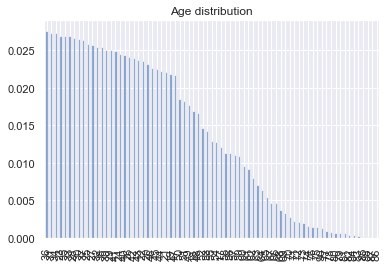

In [367]:
plt.title("Age distribution")
df["age"].value_counts(normalize=True).plot(kind="bar", alpha=.6)

## FEATURE CREATION

### Creating isInvestor Feature to show if peron was into investments

In [368]:
df["isInvestor"]=~(df["capital-gain"]==0 & (df["capital-loss"]==0))
df_test["isInvestor"]=~(df_test["capital-gain"]==0 & (df_test["capital-loss"]==0))

In [369]:
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label,isInvestor
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,True
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,False
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,False
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,False
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,False


# ENCODING ATTRIBUTES

## One Hot Encoding

In [370]:
df=pd.get_dummies(df)
df_test=pd.get_dummies(df_test)

### Method to remove cols from test frame which are not present in the main df after one hot encoding

In [371]:
for col in df_test.columns:
    if(col in df.columns):
        pass
    else:
        df_test.drop([col], axis=1, inplace=True)

### Method to add cols to test frame which are present in the main df after one hot encoding

In [372]:
for col in df.columns:
    if(col in df_test):
        pass
    else:
        df_test[col]=0

## Separating target variable from df

In [373]:
df_test_target=df_test["label_ >50K"]
df_target=df["label_ >50K"]
df_test.drop(["label_ <=50K", "label_ >50K"], axis=1, inplace=True)
df.drop(["label_ <=50K", "label_ >50K"], axis=1, inplace=True)

In [374]:
df.columns

Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'isInvestor',
       'workclass_', 'workclass_ Federal-gov', 'workclass_ Local-gov',
       'workclass_ Never-worked', 'workclass_ Private',
       ...
       'native-country_ Portugal', 'native-country_ Puerto-Rico',
       'native-country_ Scotland', 'native-country_ South',
       'native-country_ Taiwan', 'native-country_ Thailand',
       'native-country_ Trinadad&Tobago', 'native-country_ United-States',
       'native-country_ Vietnam', 'native-country_ Yugoslavia'],
      dtype='object', length=108)

# BUILDING THE DECISION TREE CLASSIFIER


In [375]:
from sklearn import tree
model_decision_tree = tree.DecisionTreeClassifier()
model_decision_tree.fit(df, df_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## SCORING THE MODEL

In [376]:
model_decision_tree.score(df_test, df_test_target)

0.8193599901725939

In [377]:
df.shape

(32561, 108)

In [378]:
df_test.shape

(16281, 108)

# BUILDING RANDOM FOREST TREE CLASSIFIER

In [379]:
from sklearn.ensemble import RandomForestClassifier

## RESULTS WITH 2 ESTIMATORS

In [380]:
model_random_forest_decision_tree = RandomForestClassifier(n_estimators=2)
model_random_forest_decision_tree.fit(df, df_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### SCORING THE MODEL

In [381]:
model_random_forest_decision_tree.score(df_test, df_test_target)

0.8258706467661692

## RESULTS WITH 4 ESTIMATORS

In [382]:
model_random_forest_decision_tree_4 = RandomForestClassifier(n_estimators=4)
model_random_forest_decision_tree_4.fit(df, df_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### SCORING THE MODEL

In [383]:
model_random_forest_decision_tree_4.score(df_test, df_test_target)

0.8399361218598366

## RESULTS WITH 8 ESTIMATORS

In [384]:
model_random_forest_decision_tree_8 = RandomForestClassifier(n_estimators=8)
model_random_forest_decision_tree_8.fit(df, df_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=8,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### SCORING THE MODEL

In [385]:
model_random_forest_decision_tree_8.score(df_test, df_test_target)

0.847798046803022

## RESULTS WITH 16 ESTIMATORS

In [386]:
model_random_forest_decision_tree_16 = RandomForestClassifier(n_estimators=16)
model_random_forest_decision_tree_16.fit(df, df_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=16,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### SCORING THE MODEL

In [387]:
model_random_forest_decision_tree_16.score(df_test, df_test_target)

0.8530188563356059

## RESULTS WITH 32 ESTIMATORS

In [388]:
model_random_forest_decision_tree_32 = RandomForestClassifier(n_estimators=32)
model_random_forest_decision_tree_32.fit(df, df_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=32,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### SCORING THE MODEL

In [389]:
model_random_forest_decision_tree_32.score(df_test, df_test_target)

0.8552300227258768

## RESULTS WITH 64 ESTIMATORS

In [390]:
model_random_forest_decision_tree_64 = RandomForestClassifier(n_estimators=64)
model_random_forest_decision_tree_64.fit(df, df_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=64,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### SCORING THE MODEL

In [391]:
model_random_forest_decision_tree_64.score(df_test, df_test_target)

0.8556599717462072

## RESULTS WITH 100 ESTIMATORS

In [392]:
model_random_forest_decision_tree_100 = RandomForestClassifier(n_estimators=100)
model_random_forest_decision_tree_100.fit(df, df_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### SCORING THE MODEL

In [393]:
model_random_forest_decision_tree_100.score(df_test, df_test_target)

0.8589767213316135

## RESULTS WITH 200 ESTIMATORS

In [394]:
model_random_forest_decision_tree_200 = RandomForestClassifier(n_estimators=200)
model_random_forest_decision_tree_200.fit(df, df_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### SCORING THE MODEL

In [395]:
model_random_forest_decision_tree_200.score(df_test, df_test_target)

0.8590381426202321

## RESULTS WITH 400 ESTIMATORS

In [396]:
model_random_forest_decision_tree_400 = RandomForestClassifier(n_estimators=400)
model_random_forest_decision_tree_400.fit(df, df_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### SCORING THE MODEL

In [397]:
model_random_forest_decision_tree_400.score(df_test, df_test_target)

0.8589153000429949

## RESULTS WITH 800 ESTIMATORS

In [398]:
model_random_forest_decision_tree_800 = RandomForestClassifier(n_estimators=800)
model_random_forest_decision_tree_800.fit(df, df_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### SCORING THE MODEL

In [399]:
model_random_forest_decision_tree_800.score(df_test, df_test_target)

0.8572569252502917

## ---Since the Accurancy of the model started to stagnate, we will stop at this point---

# CLASSIFICATION TREE PERFOMANCE ANALYSIS

## Compute the model accuracy, precision, recall and F1 score

In [400]:

from sklearn.metrics import precision_score
predicted = model_random_forest_decision_tree_100.predict(df_test)

In [401]:
macro_precision = precision_score(predicted, df_test_target, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(predicted, df_test_target, average=None)
print('Per-class precision score:', per_class_precision)

Macro-averaged precision score: 0.76
Per-class precision score: [0.94628066 0.57670307]


In [402]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(predicted, df_test_target).ravel()

In [403]:
def compute_classifier_accuracy(tp, tn, fp, fn):
    accuracy=(tp+tn)/(tp+tn+fp+fn)
    precision=tp/(tp+fp)
    recall= tp/(tp+fn)
    f1_score=(2*(precision*recall))/(precision+recall)
    return accuracy, precision, recall, f1_score

In [404]:
accuracy, precision, recall, f1_score=compute_classifier_accuracy(tp, tn, fp, fn)
print('Model Accuracy:', accuracy)
print('Model Precision:', precision)
print('Model Recall:', recall)
print('Model F1-Score:', f1_score)

Model Accuracy: 0.8589767213316135
Model Precision: 0.5767030681227249
Model Recall: 0.7685377685377686
Model F1-Score: 0.6589423648247178
